In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import luit as lt    #Custom library for SUMMA (https://github.com/msaharia/luit) 
from jupyterthemes import jtplot

jtplot.style(theme='grade3')

In [2]:
#User-supplied
obsfile = '/glade/p/work/manab/fcast/data/dly/obsflow.dly.HHDW1.csv'
routefile = '/glade/p/work/manab/fcast/PNW_route/output/17003600_out.nc'
polyshp = '/glade/p/work/manab/fcast/data/shapefile/Region_17_merged_hru.shp'
segshp =  '/glade/p/work/manab/fcast/data/shapefile/Region17_merged_seg.shp'

hid = 17007511  #HRU ID to be plotted
sid = 17003601  #Reach ID to be plotted
pltwidth = 15
pltheight = 5
starttime1 = '2010-10-01'
endtime1 = '2016-09-01'

In [3]:
summaoutfile = lt.concatHRUspatially('/glade/p/work/manab/fcast/HHDW1/output/hhdw1', 'final.nc') 
summaout = xr.open_dataset(summaoutfile)
routeout = xr.open_dataset(routefile)

Created 24 HRU-only SUMMA output file out of 24
Deleted temporary convert directory!


The 24 upstream HRU IDs are: [17007385 17007386 17007424 17007430 17007447 17007453 17007454 17007471
 17007483 17007498 17007511 17007517 17007536 17007541 17007550 17007554
 17007569 17007639 17009584 17009585 17009586 17009587 17009598 17009599]

The 12 REACH IDs are: [17003600 17003601 17003602 17003603 17003604 17003605 17003606 17003607
 17003608 17003616 17003617 17003618]



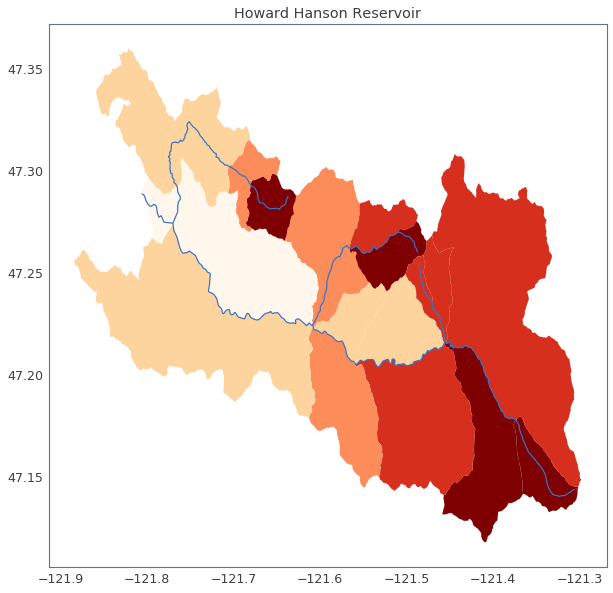

In [4]:
#Polygon shapefile
hrus = summaout['hruId'].values
print('The ' + str(len(hrus)) + ' upstream HRU IDs are: ' + str(hrus) + '\n')
polydat = lt.subShp(polyshp, 'hru_id2', hrus)

#Reach shapefile
reaches = routeout['reachID'].values
print('The ' + str(len(reaches)) + ' REACH IDs are: ' + str(reaches) + '\n')
segdat = lt.subShp(segshp, 'seg_id2', reaches)

#Plotting and overlaying
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_title('Howard Hanson Reservoir')
polydat.plot(ax = ax, column = 'Elev_Avg', cmap='OrRd', scheme='quantiles')
segdat.plot(ax = ax)
ax.grid(False)

In [5]:
# Observed streamflow
o = pd.read_csv(obsfile)
o.rename(columns = {'Year':'time', 'cfs': 'flow'}, inplace=True)

o['flow'] = o['flow']*0.028316847 #Convert to CMS
o['time'] = pd.to_datetime(o['time'])  #convert to datetime format
o.loc[o['flow'] < 0 , 'flow'] = np.nan
o.fillna(method='ffill', limit=10)

o = o.set_index(['time'])
obs = o.to_xarray()

In [6]:
#Unit conversion
out = xr.open_dataset(summaoutfile).set_index(hru = 'hruId')

#Convert gru unit to hru unit
runoffdata = out['averageInstantRunoff'].values                     #Extract averageInstantRunoff values
runoffarray = xr.DataArray(runoffdata, dims=['time','hru'])            #Create an array of averageInstantRunoff with 2 dimensions
out = out.drop('averageInstantRunoff')                           #Drop the original averageInstantRunoff variable
out['averageInstantRunoff'] = runoffarray                           #Add the new array to original netCDF
out['averageInstantRunoff'].attrs['long_name'] = "instantaneous runoff (instant)"
out['averageInstantRunoff'].attrs['units'] = 'm s-1'
        
out

<xarray.Dataset>
Dimensions:                 (hru: 24, midToto: 8, time: 19248)
Coordinates:
  * hru                     (hru) int64 17007385 17007386 17007424 17007430 ...
  * time                    (time) datetime64[ns] 2010-06-01 ...
Dimensions without coordinates: midToto
Data variables:
    pptrate                 (time, hru) float64 ...
    airtemp                 (time, hru) float64 ...
    nSnow                   (time, hru) int32 ...
    nSoil                   (time, hru) int32 ...
    nLayers                 (time, hru) int32 ...
    numberFluxCalc          (time, hru) int32 ...
    scalarSWE               (time, hru) float64 ...
    mLayerTemp              (time, midToto, hru) float64 ...
    mLayerVolFracLiq        (time, midToto, hru) float64 ...
    scalarAquiferStorage    (time, hru) float64 ...
    scalarTotalSoilWat      (time, hru) float64 ...
    scalarRainPlusMelt      (time, hru) float64 ...
    scalarSurfaceRunoff     (time, hru) float64 ...
    scalarSoilBasefl

In [7]:
out['pptrate'] = out['pptrate']*3600      #kg m-2 s-1 -> mm/hr
out['averageInstantRunoff'] = out['averageInstantRunoff']*3600000  #m/s to mm/h
out['scalarAquiferBaseflow'] = out['scalarAquiferBaseflow']*3600000  #m/s to mm/h
out['scalarRainPlusMelt'] = out['scalarRainPlusMelt']*3600000  #m/s to mm/h
out['scalarAquiferRecharge'] = out['scalarAquiferRecharge']*3600000  #m/s to mm/h
out['scalarAquiferStorage'] = out['scalarAquiferStorage']*1000  #m to mm
out['scalarAquiferTranspire'] = out['scalarAquiferTranspire']*3600000  #m/s to mm/h
out['scalarSurfaceRunoff'] = out['scalarSurfaceRunoff']*3600000  #m/s to mm/h

# Summary Statistics (20101001 - 20160901)

In [8]:
param = {}
param['aquiferScaleFactor (Smax)'] = '3'
param['aquiferBaseflowRate(K)'] = '0.1'
param['aquiferBaseflowExp(c)'] = '1.5'

statsum = {}
statsum['pptrate (mm/h)'] = out['pptrate'].loc[starttime1:endtime1].sum().values
statsum['averageInstantRunoff (mm/h)'] = out['averageInstantRunoff'].loc[starttime1:endtime1].sum().values
statsum['scalarRainPlusMelt (mm/h)'] = out['scalarRainPlusMelt'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferRecharge (mm/h)'] = out['scalarAquiferRecharge'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferBaseflow (mm/h)'] = out['scalarAquiferBaseflow'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferStorage (mm)'] = out['scalarAquiferStorage'].loc[starttime1:endtime1].sum().values
statsum['scalarAquiferTranspire (mm/h)'] = out['scalarAquiferTranspire'].loc[starttime1:endtime1].sum().values

statavg = {}
statavg['pptrate (mm/h)'] = out['pptrate'].loc[starttime1:endtime1].mean().values
statavg['averageInstantRunoff (mm/h)'] = out['averageInstantRunoff'].loc[starttime1:endtime1].mean().values
statavg['scalarRainPlusMelt (mm/h)'] = out['scalarRainPlusMelt'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferRecharge (mm/h)'] = out['scalarAquiferRecharge'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferBaseflow (mm/h)'] = out['scalarAquiferBaseflow'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferStorage (mm)'] = out['scalarAquiferStorage'].loc[starttime1:endtime1].mean().values
statavg['scalarAquiferTranspire (mm/h)'] = out['scalarAquiferTranspire'].loc[starttime1:endtime1].mean().values

#totalbaseflow = statsum['scalarAquiferBaseflow (mm/h)'] 
#totalstreamflow = out.sel(hru = hid)['scalarAquiferRecharge'].loc[starttime1:endtime1].sum().values

#bfi = totalbaseflow / totalstreamflow
#print(bfi)

print('\n BASEFLOW PARAMETERS')
for x in param:
    print (x,':',param[x])
    
    
print('\n SUM')
for x in statsum:
    print (x,':',statsum[x])
    
print('\n AVERAGE')
for x in statavg:
    print (x,':',statavg[x])


 BASEFLOW PARAMETERS
aquiferScaleFactor (Smax) : 3
aquiferBaseflowRate(K) : 0.1
aquiferBaseflowExp(c) : 1.5

 SUM
pptrate (mm/h) : 97774.74092700548
averageInstantRunoff (mm/h) : 144831.05708370282
scalarRainPlusMelt (mm/h) : 62247.53070560233
scalarAquiferRecharge (mm/h) : 72415.53271593338
scalarAquiferBaseflow (mm/h) : 72415.52436777246
scalarAquiferStorage (mm) : 62008.937747949676
scalarAquiferTranspire (mm/h) : 0.0

 AVERAGE
pptrate (mm/h) : 0.23543386145545703
averageInstantRunoff (mm/h) : 0.34874175788763395
scalarRainPlusMelt (mm/h) : 0.14988714243720702
scalarAquiferRecharge (mm/h) : 0.174370888994677
scalarAquiferBaseflow (mm/h) : 0.17437086889296421
scalarAquiferStorage (mm) : 0.14931262942082196
scalarAquiferTranspire (mm/h) : 0.0


# PLOTS

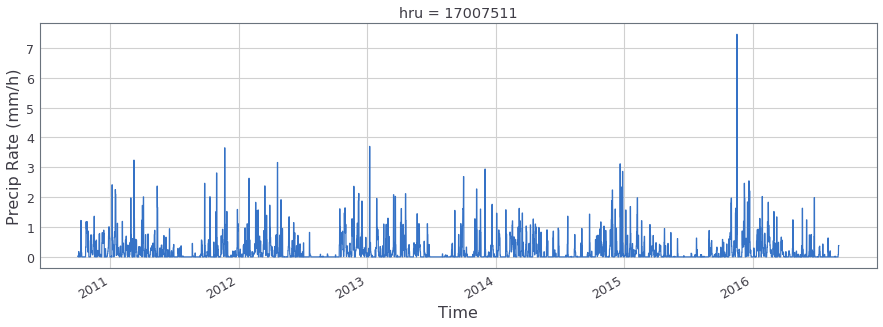

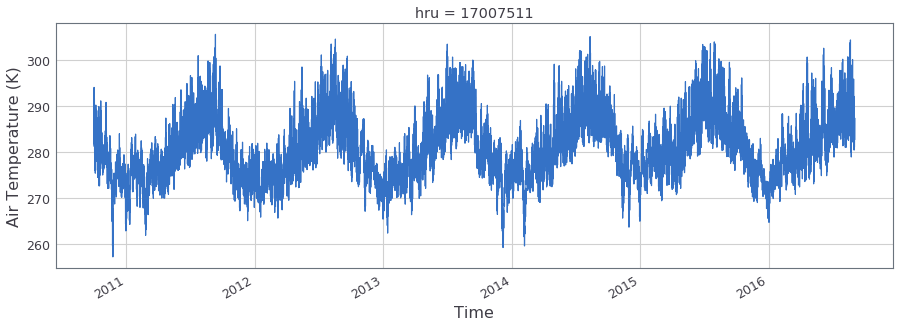

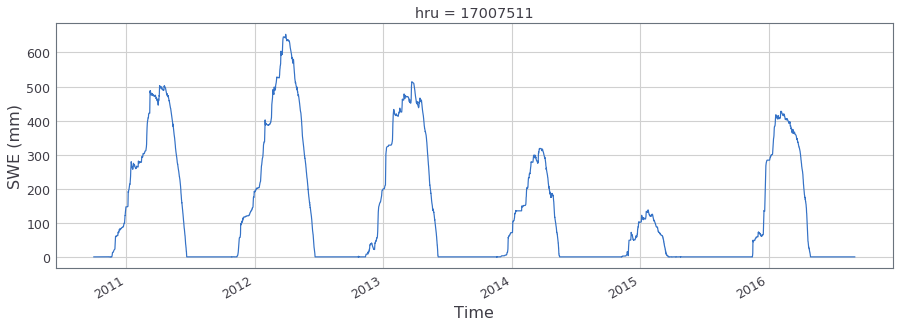

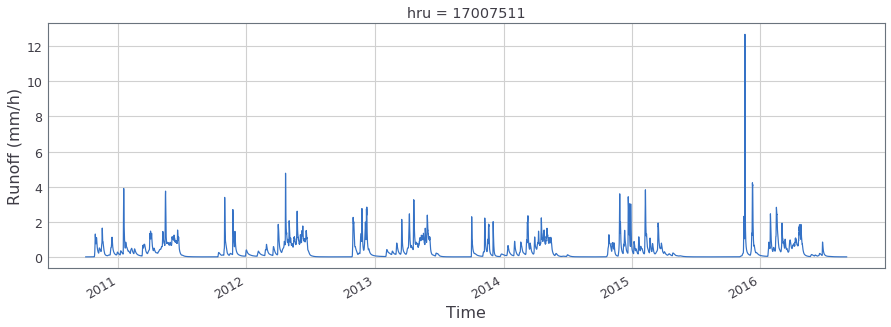

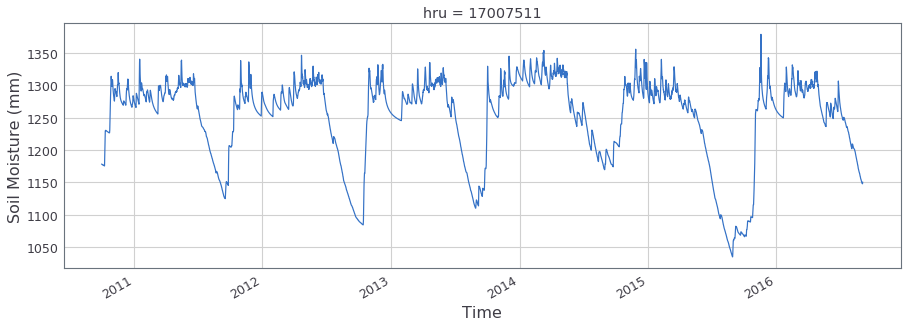

In [9]:
#Plot forcing and diagnostic variables
# PPTRATE
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['pptrate'].loc[starttime1:endtime1].plot()
plt.ylabel('Precip Rate (mm/h)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/pptrate.png', bbox_inches='tight', dpi=300)
plt.show()

# AIRTEMP
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['airtemp'].loc[starttime1:endtime1].plot()
plt.ylabel('Air Temperature (K)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/pptrate.png', bbox_inches='tight', dpi=300)
plt.show()

# SWE
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarSWE'].loc[starttime1:endtime1].plot()
plt.ylabel('SWE (mm)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/swe.png', bbox_inches='tight', dpi=300)
plt.show()

#averageInstantRunoff
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['averageInstantRunoff'].loc[starttime1:endtime1].plot()
plt.ylabel('Runoff (mm/h)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/runoff.png', bbox_inches='tight', dpi=300)
plt.show()

#scalarTotalSoilWat
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarTotalSoilWat'].loc[starttime1:endtime1].plot()
plt.ylabel('Soil Moisture (mm)', fontsize=16)
plt.xlabel('Time', fontsize=16)
#plt.savefig('figures/sm.png', bbox_inches='tight', dpi=300)
plt.show()



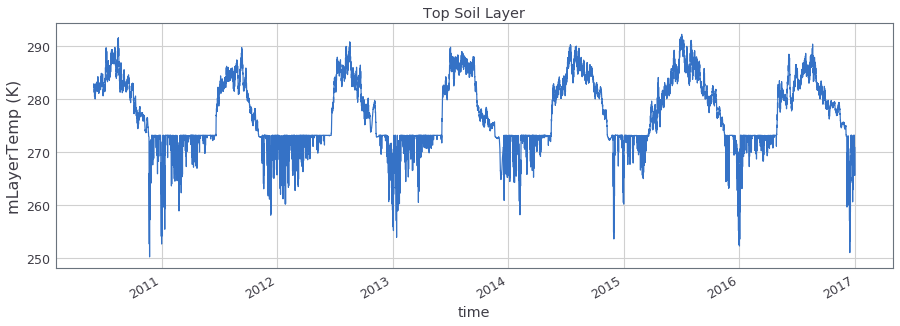

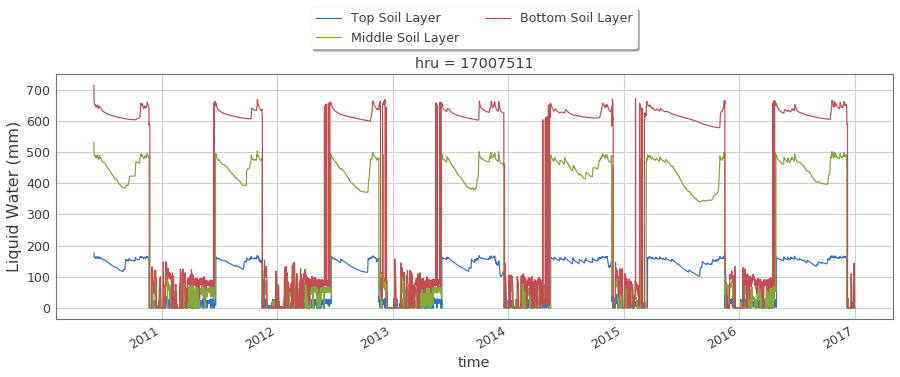

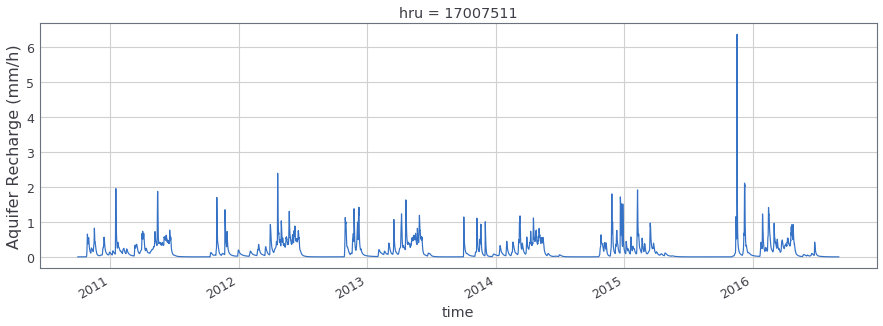

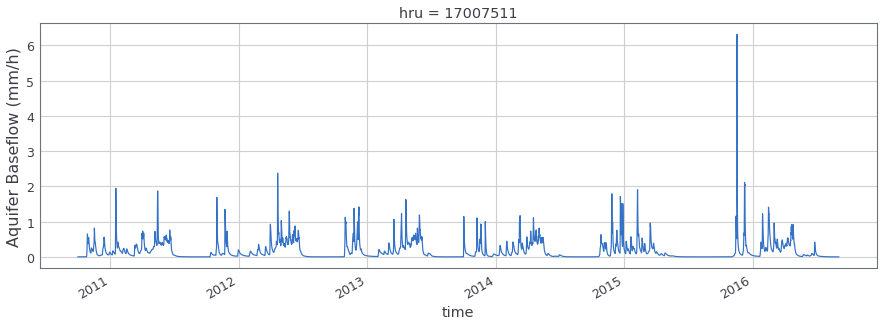

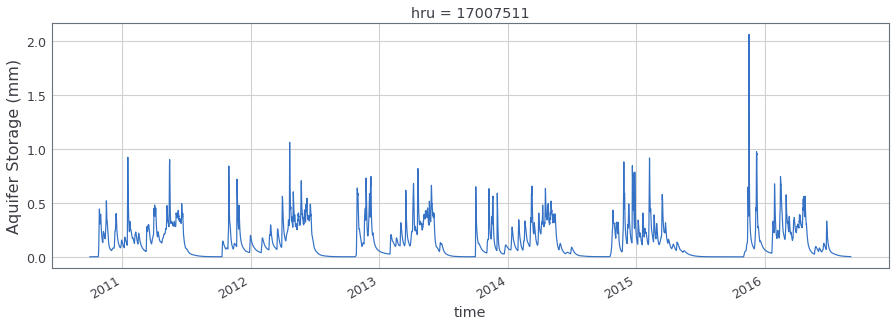

In [10]:
#mLayerTemp
plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru=hid)['mLayerTemp'][:, 0].plot(label = 'Top')
plt.ylabel('mLayerTemp (K)', fontsize = 16)
plt.title('Top Soil Layer')
plt.show()

#mLayerVolFracLiq
iden_water = 1000
plt.figure(figsize=(pltwidth, pltheight))
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 0]*iden_water*0.5).plot(label='Top Soil Layer')
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 1]*iden_water*1.5).plot(label='Middle Soil Layer')
(out.sel(hru = hid)['mLayerVolFracLiq'][:, 2]*iden_water*2.0).plot(label='Bottom Soil Layer')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=True)
plt.ylabel('Liquid Water (mm)', fontsize=16) 
plt.show()


plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarAquiferRecharge'].loc[starttime1:endtime1].plot()
plt.ylabel('Aquifer Recharge (mm/h)', fontsize=16)
plt.show()


plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarAquiferBaseflow'].loc[starttime1:endtime1].plot()
plt.ylabel('Aquifer Baseflow (mm/h)', fontsize=16)
plt.show()

plt.figure(figsize=(pltwidth, pltheight))
out.sel(hru = hid)['scalarAquiferStorage'].loc[starttime1:endtime1].plot()
plt.ylabel('Aquifer Storage (mm)', fontsize=16)
plt.show()


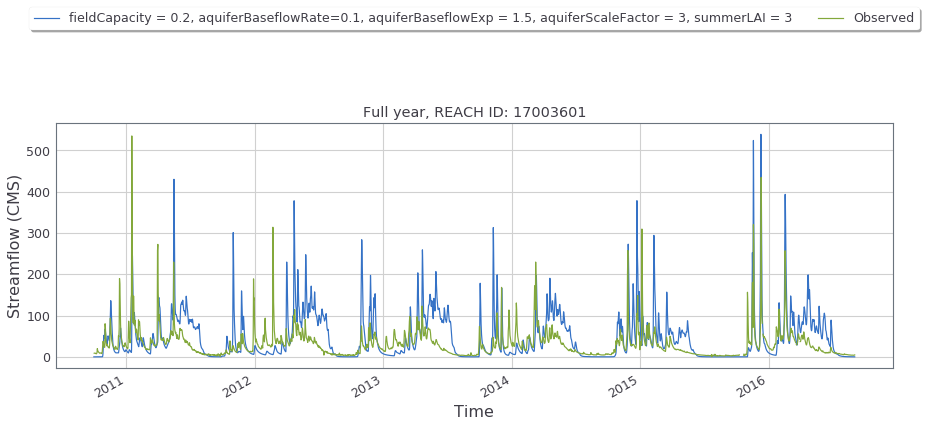

In [11]:
#Streamflow
routeout = xr.open_dataset(routefile).set_index(sSeg = 'reachID')

#PLOT 1
plt.figure(figsize=(pltwidth,pltheight))
routeout.sel(sSeg = sid)['IRFroutedRunoff'].loc[starttime1:endtime1].plot(label='fieldCapacity = 0.2, aquiferBaseflowRate=0.1, aquiferBaseflowExp = 1.5, aquiferScaleFactor = 3, summerLAI = 3')
(obs['flow'].loc[starttime1:endtime1]).plot(label='Observed')
plt.ylabel('Streamflow (CMS)', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('Full year, REACH ID: %i' %sid)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=True)
plt.show()